In [1]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
from matplotlib.dates import DateFormatter
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn import metrics

In [2]:
df = pd.read_csv('../input/environmental-sensor-data-132k/iot_telemetry_data.csv')

In [3]:
df.replace(['00:0f:00:70:91:0a', '1c:bf:ce:15:ec:4d', 'b8:27:eb:bf:9d:51'], [1, 2, 3], inplace=True)
df['light'] = df['light']*1
df['motion'] = df['motion']* 1

In [4]:
# convert temperature from celsius to fahrenheit (°C to °F)
df['temp'] = (df['temp'] * 1.8) + 32

In [5]:
# filter temp/humidity, by device, for outliers (>1% & <99%)
df = df.loc[df['temp'] >df.groupby('device').temp.transform(lambda x: x.quantile(.01))]
df = df.loc[df['temp'] < df.groupby('device').temp.transform(lambda x: x.quantile(.99))]

df = df.loc[df['humidity'] > df.groupby('device').humidity.transform(lambda x: x.quantile(.01))]
df = df.loc[df['humidity'] < df.groupby('device').humidity.transform(lambda x: x.quantile(.99))]

In [6]:
# convert unix time to time of day
from datetime import datetime, timedelta
start = datetime(1970, 1, 1)  # Unix epoch start time
df['datetime'] = df.ts.apply(lambda x: start + timedelta(seconds=x))
#df['string_time'] = df.datetime.apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

In [7]:
data = df.set_index('datetime')

In [8]:
data = data[['co','humidity', 'light', 'lpg', 'smoke', 'temp', 'motion']]

In [9]:
data

,co,humidity,light,lpg,smoke,temp,motion
datetime,,,,,,,
2020-07-12 00:01:34.385975,0.004956,51.000000,0,0.007651,0.020411,72.860000,0
2020-07-12 00:01:34.735568,0.002840,76.000000,0,0.005114,0.013275,67.460001,0
2020-07-12 00:01:38.073573,0.004976,50.900000,0,0.007673,0.020475,72.680000,0
2020-07-12 00:01:39.589146,0.004403,76.800003,1,0.007023,0.018628,80.600000,0
2020-07-12 00:01:41.761235,0.004967,50.900000,0,0.007664,0.020448,72.680000,0
...,...,...,...,...,...,...,...
2020-07-20 00:03:33.162015,0.003745,75.300003,0,0.006247,0.016437,66.560001,0
2020-07-20 00:03:33.576561,0.005882,48.500000,0,0.008660,0.023301,71.960000,0
2020-07-20 00:03:36.167959,0.004540,75.699997,1,0.007181,0.019076,79.880001,0


### Converting Time series to Supervised Learning problem

##### We have readings at time t and want to predict motion readings at time, t+N where N represents future time intervals
##### we will use the pandas shift() function to create this lag features. Shifting the columns by N creates columns with N nan values. In our case, N will be 1, that is, at time t-1, we will becreating lag for the next time step, t


In [11]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols,names = list(),list()
    # input sequence(t-n,...t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+= [('var%d(t-%d)'%(j+1,i))for j in range(n_vars)]
    #forecase sequence (t t+1,....,t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-1))
        names = ['co', 'humidity', 'light', 'lpg', 'smoke', 'temp', 'motion', 'co1', 'humidity1', 'light1', 'lpg1', 'smoke1', 'temp1', 'motion1']
    #put it all together
    agg = concat(cols,axis=1)
    agg.columns = names
    #drop rows with nan values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
values = data.values

In [13]:
data2= series_to_supervised(data)

In [14]:
data2

,co,humidity,light,lpg,smoke,temp,motion,co1,humidity1,light1,lpg1,smoke1,temp1,motion1
datetime,,,,,,,,,,,,,,
2020-07-12 00:01:34.735568,0.004956,51.000000,0.0,0.007651,0.020411,72.860000,0.0,0.004976,50.900000,0.0,0.007673,0.020475,72.680000,0.0
2020-07-12 00:01:38.073573,0.002840,76.000000,0.0,0.005114,0.013275,67.460001,0.0,0.004403,76.800003,1.0,0.007023,0.018628,80.600000,0.0
2020-07-12 00:01:39.589146,0.004976,50.900000,0.0,0.007673,0.020475,72.680000,0.0,0.004967,50.900000,0.0,0.007664,0.020448,72.680000,0.0
2020-07-12 00:01:41.761235,0.004403,76.800003,1.0,0.007023,0.018628,80.600000,0.0,0.004391,77.900002,1.0,0.007009,0.018589,80.600000,0.0
2020-07-12 00:01:44.468411,0.004967,50.900000,0.0,0.007664,0.020448,72.680000,0.0,0.004976,50.900000,0.0,0.007673,0.020475,72.680000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20 00:03:30.755704,0.005877,48.500000,0.0,0.008654,0.023284,72.140000,0.0,0.003745,75.300003,0.0,0.006247,0.016437,66.560001,0.0
2020-07-20 00:03:33.162015,0.004553,75.800003,1.0,0.007196,0.019117,79.880001,0.0,0.005882,48.500000,0.0,0.008660,0.023301,71.960000,0.0
2020-07-20 00:03:33.576561,0.003745,75.300003,0.0,0.006247,0.016437,66.560001,0.0,0.004540,75.699997,1.0,0.007181,0.019076,79.880001,0.0


In [15]:
#data2.columns = ['device', 'co', 'humidity', 'light', 'lpg', 'smoke', 'temp', 'motion','device1', 'co1', 'humidity1', 'light1', 'lpg1', 'smoke1', 'temp1', 'motion1']

In [16]:
X= data2.drop(columns = ['temp1'])
y = data2['temp1']

In [17]:
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)

In [19]:
X_train= X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [20]:
rf = RandomForestRegressor(n_jobs=-1) 

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


score_rf = rf.score(X_test, y_test)
print('test accuracy:')
print(score_rf)
print('train accuracy')
print(rf.score(X_train, y_train))
print('mean squared error:')
print(mean_squared_error(y_pred, y_test))
print('mean_absolute_error')
print(mean_absolute_error(y_pred, y_test))

test accuracy:
0.9980838279341449
train accuracy
0.99971430163004
mean squared error:
0.04309133925103953
mean_absolute_error
0.08781709078114214


In [21]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

cat.fit(X_train,y_train)

y_pred = cat.predict(X_test)

score_cat = cat.score(X_test, y_test)
print('test accuracy:')
print(score_cat)
print('train accuracy')
print(cat.score(X_train, y_train))
print('mean squared error:')
print(mean_squared_error(y_pred, y_test))
print('mean_absolute_error')
print(mean_absolute_error(y_pred, y_test))

Learning rate set to 0.105714
0:	learn: 4.3231541	total: 88.8ms	remaining: 1m 28s
1:	learn: 3.9345751	total: 114ms	remaining: 56.8s
2:	learn: 3.5828169	total: 140ms	remaining: 46.7s
3:	learn: 3.2757641	total: 165ms	remaining: 41.1s
4:	learn: 3.0072728	total: 190ms	remaining: 37.9s
5:	learn: 2.7678604	total: 219ms	remaining: 36.2s
6:	learn: 2.5593988	total: 244ms	remaining: 34.6s
7:	learn: 2.3741792	total: 268ms	remaining: 33.2s
8:	learn: 2.2118581	total: 296ms	remaining: 32.6s
9:	learn: 2.0696065	total: 321ms	remaining: 31.7s
10:	learn: 1.9457546	total: 346ms	remaining: 31.1s
11:	learn: 1.8411457	total: 371ms	remaining: 30.5s
12:	learn: 1.7462265	total: 395ms	remaining: 30s
13:	learn: 1.6656190	total: 422ms	remaining: 29.7s
14:	learn: 1.5918665	total: 445ms	remaining: 29.2s
15:	learn: 1.5322055	total: 471ms	remaining: 28.9s
16:	learn: 1.4787431	total: 498ms	remaining: 28.8s
17:	learn: 1.4317864	total: 524ms	remaining: 28.6s
18:	learn: 1.3940467	total: 550ms	remaining: 28.4s
19:	learn: 

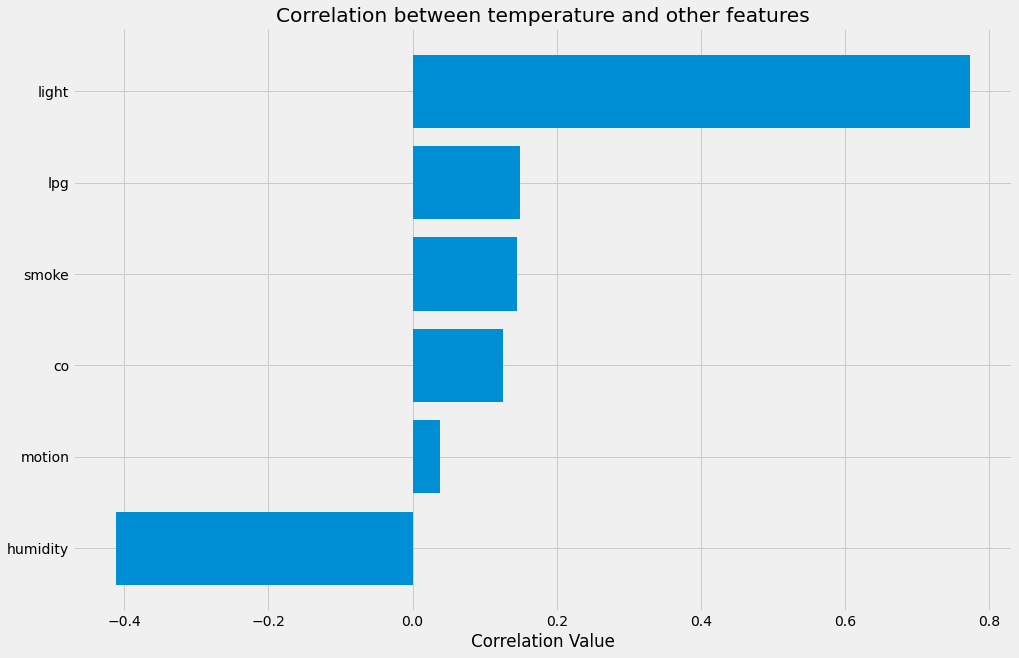

In [23]:
corrwith = pd.DataFrame((data.drop(columns = 'temp')).corrwith(data["temp"]), columns = (['value'])).sort_values(by = 'value', ascending = 'True')
corrwith
vals = np.arange(len(corrwith.value))
plt.figure(figsize=(15, 10))
plt.barh(vals, corrwith.value)
plt.yticks(vals, corrwith.index)
plt.xlabel('Correlation Value')
plt.title('Correlation between temperature and other features')
plt.savefig('corrwithTarget.png')

### Accuracy plots

Text(0.5, 1.0, 'Model Results')

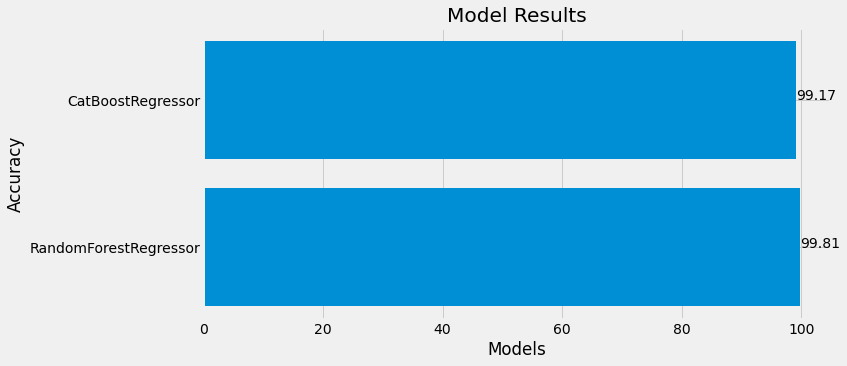

In [24]:
results = [round(score_rf*100, 2), round(score_cat*100, 2)]
names = ['RandomForestRegressor', 'CatBoostRegressor']
plt.figure(figsize=(10, 5))
plt.barh(names,results)

for index, value in enumerate(results):
    plt.text(value, index, str(value))
plt.xlabel('Models')
plt.ylabel("Accuracy")
plt.title('Model Results')

In [28]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    #names = ['device', 'co', 'humidity', 'light', 'lpg', 'smoke', 'temp', 'motion','device1', 'co1', 'humidity1', 'light1', 'lpg1', 'smoke1', 'motion1']
    names = X.columns
    feature_names = np.array(names)
    #feature_names = X_train.columns
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette = 'Blues_r')

    #Add chart labels
    plt.title(model_type + ' Feature Importance')

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.savefig('feat_imp.png')

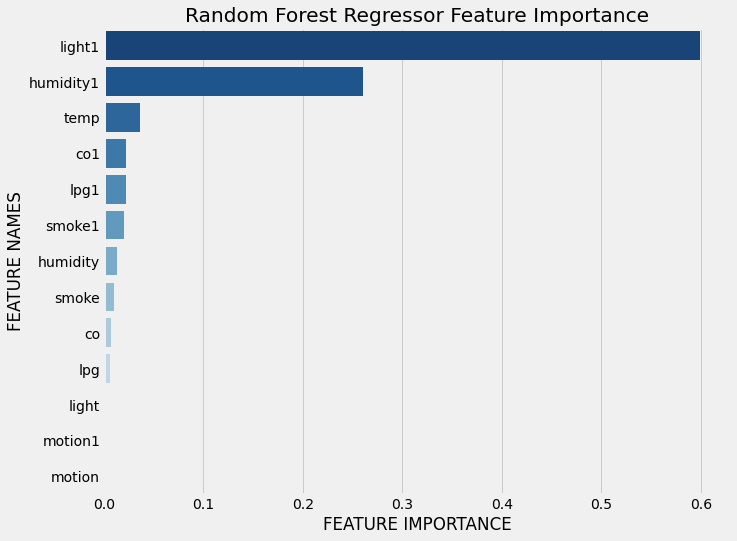

In [30]:
plot_feature_importance(rf.feature_importances_,names,'Random Forest Regressor')

### Model Explainability with Accumulated Local Effects

In [31]:
pip install alibi

Note: you may need to restart the kernel to use updated packages.


In [32]:
from alibi.explainers import ALE, plot_ale

In [ ]:
f_names = ['co', 'humidity', 'light', 'lpg', 'smoke', 'temp', 'motion', 'co1', 'humidity1', 'light1', 'lpg1', 'smoke1', 'motion1']

In [44]:
rf_ale = ALE(rf.predict, feature_names=X.columns, target_names=['Temperature at time=t'])

In [45]:
rf_exp = rf_ale.explain(X_train)

In [ ]:
#rf_exp

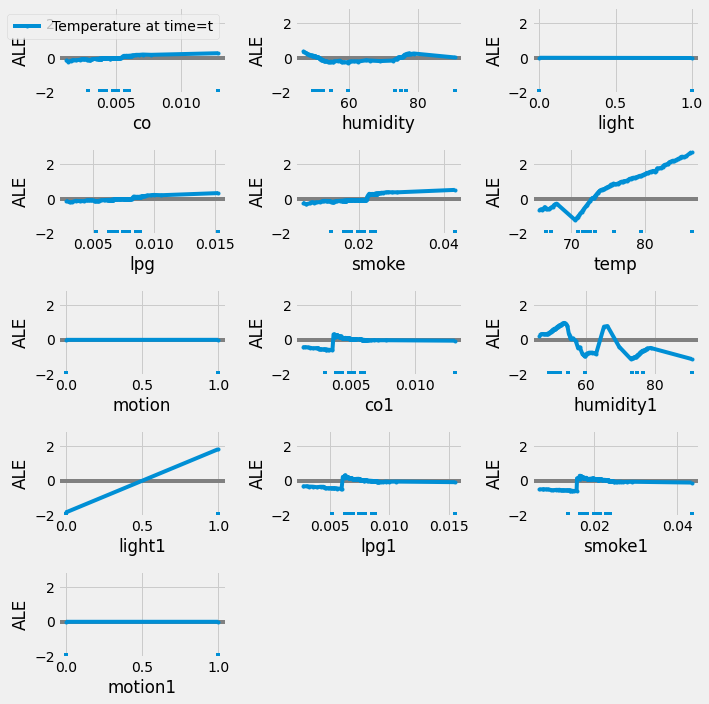

In [46]:
axes = plot_ale(rf_exp, fig_kw={'figwidth':10, 'figheight': 10});

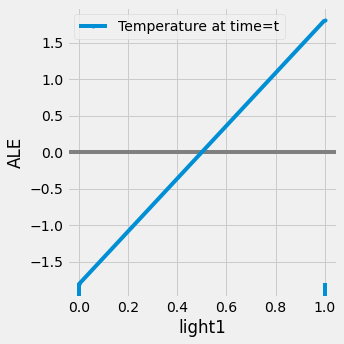

In [47]:
 plot_ale(rf_exp, features = ['light1'],fig_kw={'figwidth':5, 'figheight': 5});

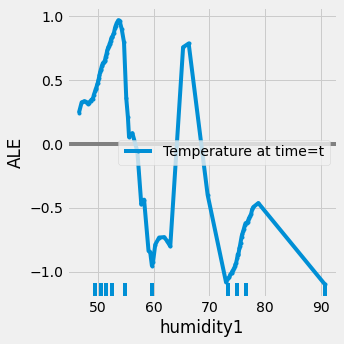

In [48]:
 plot_ale(rf_exp, features = ['humidity1'],fig_kw={'figwidth':5, 'figheight': 5});

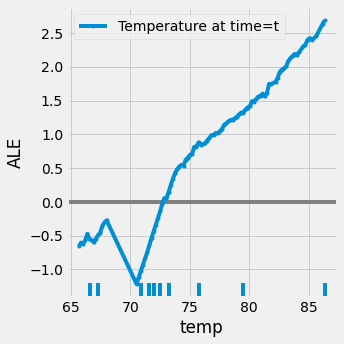

In [49]:
 plot_ale(rf_exp, features = ['temp'],fig_kw={'figwidth':5, 'figheight': 5});

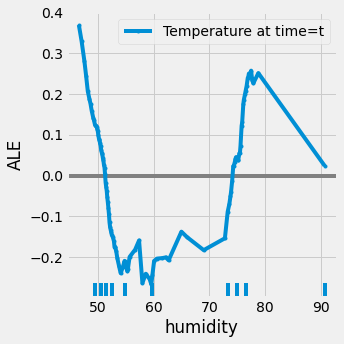

In [50]:
 plot_ale(rf_exp, features = ['humidity'],fig_kw={'figwidth':5, 'figheight': 5});

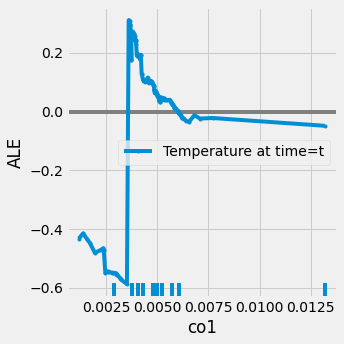

In [51]:
 plot_ale(rf_exp, features = ['co1'],fig_kw={'figwidth':5, 'figheight': 5});

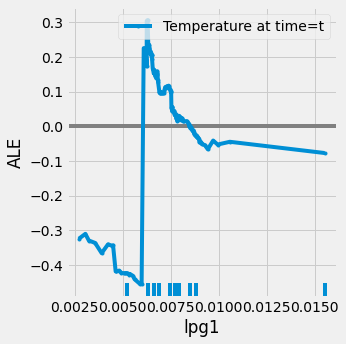

In [52]:
 plot_ale(rf_exp, features = ['lpg1'],fig_kw={'figwidth':5, 'figheight': 5});

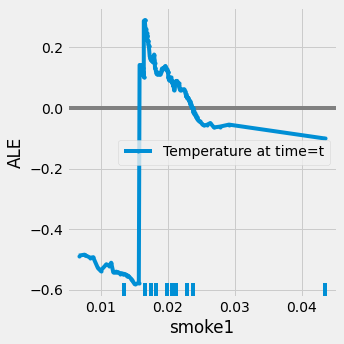

In [53]:
 plot_ale(rf_exp, features = ['smoke1'],fig_kw={'figwidth':5, 'figheight': 5});